In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import cvxpy
import time

import multiprocessing as mp
from tqdm import tqdm

In [2]:
import io_utils
import kernels
import algos
from importlib import reload
reload(io_utils)

<module 'io_utils' from '/home/victor/Data/Mines-ParisTech/M2/mva/S2/km/kernel-methods/io_utils.py'>

### Create experiment and load datasets

In [14]:
np.random.seed(42)

exp = io_utils.Experiment()
exp.create_new_experiment()

### Compute substring kernel for all datasets

In [15]:
pool = mp.Pool(6)
# Compute kernels
kernels_train, kernels_val = [], []

kern_ss = kernels.SubstringKernel(7, 0.1)

for n in range(3):
    print("Processing dataset {}".format(n))
    n_train, n_val = exp.raw_train[n].shape[0], exp.raw_val[n].shape[0]
    
    t = time.time()
    args = [(exp.raw_train[n][i], exp.raw_train[n][j]) for i in range(n_train) for j in range(i, n_train) ]
    result = pool.map(kern_ss.computeKernel, args)
    e = time.time()
    print("Kernel computation took {:.2f} seconds".format(e-t))
    
    count = 0
    K = np.zeros((n_train, n_train))
    for i in range(n_train):
        for j in range(i, n_train):
            K[i,j] = result[count]
            count +=1

    for i in range(n_train):
        for j in range(0, i):
            K[i,j] = K[j,i]
  
    kernels_train.append(K.copy())
    args = [(exp.raw_train[n][i], exp.raw_val[n][j]) for i in range(n_train) for j in range(n_val) ]
    
    result = pool.map(kern_ss.computeKernel, args)
    intermediate = np.zeros((n_train, n_val))
    count = 0
    for i in range(n_train):
        for j in range(n_val):
            intermediate[i,j] = result[count]
            count +=1
    kernels_val.append(intermediate.copy())



Processing dataset 0
Kernel computation took 8.47 seconds
Processing dataset 1
Kernel computation took 6.86 seconds
Processing dataset 2
Kernel computation took 7.83 seconds


### If needed, save experiment

In [5]:
exp.save('kernels/substring_4_01', kernels_train, kernels_val)

### (Optional) Compute matrices needed for testing 

In [7]:
# Test
exp.load_all_test_datasets()

kernels_test = []

for i in range(3):    
    print("Processing dataset {}".format(i))
    n1, n2 = exp.raw_train[i].shape[0], exp.raw_test[i].shape[0]
    args = [(exp.raw_train[i][j], exp.raw_test[i][k]) for j in range(n1) for k in range(n2) ]
    result = pool.map(kern_ss.computeKernel, args)

    kernel_test = np.zeros((n1, n2))

    count = 0
    for k in range(n1):
        for l in range(n2):
            kernel_test[k,l] = result[count]
            count +=1
            
    kernels_test.append(kernel_test.copy())

Processing dataset 0
100
Processing dataset 1
100
Processing dataset 2
100


## Start here to load saved kernels

In [17]:
exp = io_utils.Experiment()
kernels_train, kernels_val = exp.load("kernels/substring_3_01")

### Linear kernel

In [18]:
linear_kernel = kernels.LinearKernel()
K_linear_train, K_linear_val = [], []
for i in range(3):
    K_linear_train.append(linear_kernel.computeVectorizedKernel(exp.feats_train[i], exp.feats_train[i]))
    K_linear_val.append(linear_kernel.computeVectorizedKernel(exp.feats_train[i], exp.feats_val[i]))    

In [19]:
## Prediction 
lambd = 7e-1
lambd2 = 7e-6
TRIALS = 30

lambda_vals = np.logspace(-7, -3, TRIALS)

all_preds = []

krr = algos.KernelRidgeRegression()

weights = np.ones((3,2))

for i in range(3):
    krr.fit(kernels_train[i], exp.labels_train[i], lambd)
    error_1 = krr.evaluatePerformance(kernels_val[i], exp.labels_val[i])
    predictions_1 = np.einsum('i, ij->j', krr.alpha, kernels_val[i])

    krr.fit(K_linear_train[i], exp.labels_train[i], lambd2)
    error_2 = krr.evaluatePerformance(K_linear_val[i], exp.labels_val[i])
    w_1 = (1-error_2)/(1-error_1)
    predictions_2 = np.einsum('i, ij->j', krr.alpha, K_linear_val[i])

    global_error = 1 / (w_1 + 1) * predictions_1 + w_1 / (w_1 + 1) * predictions_2
    print(np.round(1-np.sum(np.sign(global_error) != np.sign(exp.labels_val[i])) / exp.labels_val[i].shape[0],3))
    print("----")

# Test
#     pred_test = krr.predict(kernel_tests[i])
#     all_preds.append(pred_test.copy())

    

Score : 0.605
Score : 0.588
0.628
----
Score : 0.633
Score : 0.573
0.617
----
Score : 0.690
Score : 0.698
0.715
----


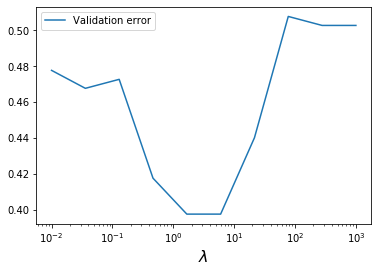

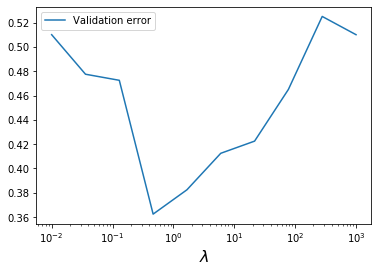

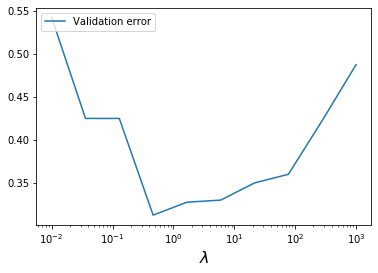

In [23]:
TRIALS = 10

lambda_vals = np.logspace(-2, 3, TRIALS)

krr = algos.KernelRidgeRegression()
for i in range(3):
    errors = krr.searchBestParameters(kernels_train[i], exp.labels_train[i], kernels_val[i], exp.labels_val[i], lambda_vals)